# PV Temperature Model Validation
###### Lelia Deville - SAND2023-11364O

#### The purpose of this notebook is to validate the use of new or current module/cell temperature models through multiple steps of analysis. 

#### The model input data comes from the published results of the 2021 Blind Modeling Comparison. In the following notebook the data collected in S2 is used, which is from the Canadian Solar 275W system at Sandia National Labs in Albuquerque, NM from  Jan 2021 - Dec 2021. More information about the dataset can be found at the [DuraMAT Data Hub](https://datahub.duramat.org/dataset/pv-performance-modeling-data/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5) and the [published results of the 2021 Blind Modeling Comparison](https://onlinelibrary.wiley.com/doi/pdf/10.1002/pip.3729) 

#### To demonstrate the way this notebook should work, a pvlib-python model, specifically Faiman,  is used in place of a user defined model. To use this notebook for a custom model, simply replace the Faiman model defined in _3: Run model to be validated or import model results_. If the model is run by an external program, it is also possible to import only the results to use in the validation and analysis. 

#### The notebook is segmented into 4 sections:

<li><b>1. Import data from DuraMAT</b></li>
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [1]:
#import necessary packages and set default formatting for plots
import matplotlib.pyplot as plt #v. 3.7.2
from matplotlib.lines import Line2D #v. 3.7.2
import numpy as np #v. 1.24.3
import seaborn as sns #v 0.13.0
import pandas as pd #v. 2.0.3
import pvlib #v. 0.9.3
import scipy #v. 1.11.1
from tabulate import tabulate #v. 0.8.10

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12
pd.options.mode.chained_assignment = None

## 1. Import data

This section imports the meteo and system data from the DuraMAT Datahub. For the purpose of accurate solar position calculations, the times are set to be labeled at the middle-of-hour. The data includes 2 filters: _bsrn pass_ and _SNL No Snow_. The baseline surface radiation network (BSRN) filter follows [version 2 quality control tests](https://epic.awi.de/id/eprint/30083/1/BSRN_recommended_QC_tests_V2.pdf) and the SNL No Snow filter removes any days with recorded snow fall or snow depth. Data is removed if either filter value is '0'. For the meteo data, any 0 values are replaced with NaNs so that statistical values, like mean, are not affected by these values. 

In [2]:
# read in data from duramat data hub directly
df = pd.read_excel("https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/  \
            pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,sheet_name='S2'")
#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

#apply the filters that are included in the data & replacing any 0 with nan so they dont affect error metrics
#dropping nans helps keep size down so operations run more quickly and smoothly
df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data
'module' is a dictionary of module specific values for 275 W mono-Si Canadian Solar modules and includes system and module data. All data for this system can be found in the various reports on the [PVPMC Wesbite](https://pvpmc.sandia.gov/datasets/pv-lifetime-module-datasets-clone/). Solar position calculations generate azimuth, zenith, elevation, etc for every timestep in the df

In [3]:
#Defining constants and values that are consistent across all calculations
#we are using S2 from the data, which is the Candian Solar Monocrystalline 275W module
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 
          'iam30': 1.0002, 'iam40':0.9984, 'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 
          'iam80':0.6778, 'iam85': 0.4351,'U0': 28.825, 'U1': 4.452, 'NOCT': 45, 'Unit Mass': 11.119,'Area':1.621,'Vmp': 31.48 ,'Imp': 8.81,'Voc':38.29 ,
          'Isc': 9.30,'Pmp': 275,'Gamma Pmp': -0.0041,'Alpha Isc':0.0033,'Beta Voc': -0.1178,'Cell Type':'monoSi','Cells in Series':60}
module = pd.Series(module)

#Running solar position calculations
spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
spdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = spdf['dni_extra'])
df['Airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])

spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135,1413.981805
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597,1413.981805
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049,1413.981805
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492,1413.981805
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925,1413.981805


Many temperature models require effective irradiance. To calculate this, the pvlib-python `pvlib.irradiance.get_total_irradiance` function with the Perez model is used to get direct and diffuse components of POA. The values are then used in the effective irradiance equation originally defined by [King in 1983](https://www.osti.gov/servlets/purl/919131). To determine IAM values, the coefficients described in the module dictionary & [IAM+NMOT Report](https://pvpmc.sandia.gov/download/3621/) are used as input into the `pvlib.iam.interp` function. Spectral effects were neglected since there were no module-specific AM coefficients available.

In [4]:
#Calculate Environmental Conditions
edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
        ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model ='perez', model_perez='albuquerque1988')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)
df['AOI'] = edf['aoi']

#Calculate Effective Irradiance
ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
df['IAMs'] = pvlib.iam.interp(aoi=edf['aoi'],theta_ref=ref_thetas,iam_ref=ref_iams )
df['Effective Irradiance'] = (edf['poa_direct'] * df['IAMs'] + edf['poa_diffuse'])

## 3. Run the model or import the results to be validated

A model can either be defined and run within this notebook or could be run externally and the results imported below. For demonstration purposes the `pvlib.temperature.faiman` function is used but should be replaced by the user's model. 

In [5]:
#Either run a model in this notebook or import the results into the column name below

#NOTE: if the model used calculates cell temperature it will need to be 
#converted to module temperature for a fair comparison with measured module temperature
# can use pvlib.temperature.sapm_cell_from_module

#run model here
df['Modeled Temp'] = pvlib.temperature.faiman(poa_global=df['Measured front POA irradiance (W/m2)'], 
        temp_air=df['Ambient Temp (°C) '], wind_speed=df['Wind Speed (m/s)'],u0=module['U0'], u1=module['U1'])

# or import model results here --- make sure timestamps line up and are middle-of-hour
# df['Modeled Temp'] = pd.read_excel('results.xlsx')

#specify a model name for use in analysis and plotting
model_name = 'Faiman'

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious errors like time shifts or magnitude differences

Text(0.5, 0, 'Time')

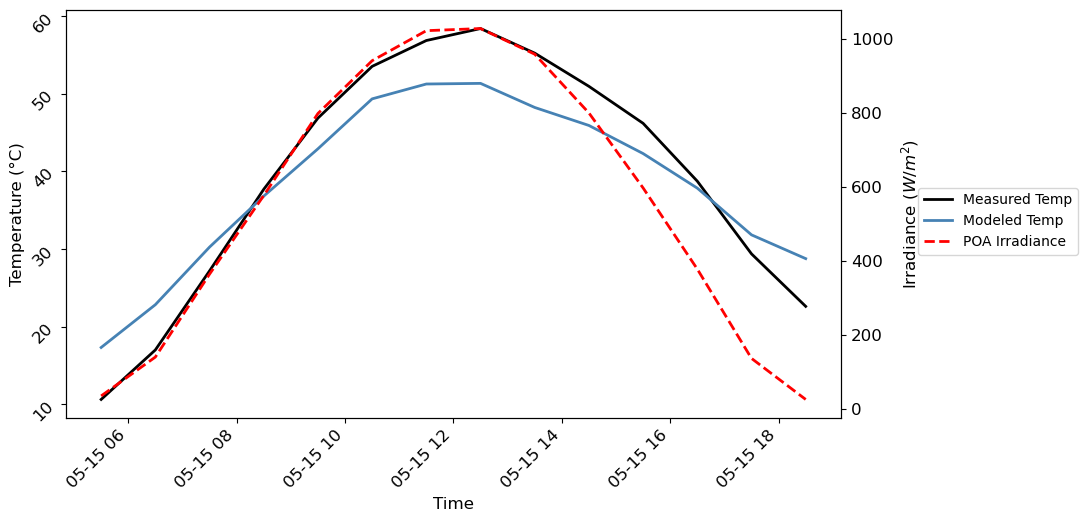

In [6]:
#diurnal plot
date = '2021-05-15'
fig, ax = plt.subplots()
ax2 = ax.twinx()
df.loc[date, 'Measured module temperature (°C)'].plot(ax=ax, label='Measured Temp', linewidth=2, color='black', zorder=5.5)
df.loc[date, 'Modeled Temp'].plot(ax=ax, label='Modeled Temp', linewidth=2, color='steelblue', zorder=5.5)
df.loc[date, 'Measured front POA irradiance (W/m2)'].plot(ax=ax2, label='POA Irradiance', linewidth=2, color='red', zorder=2.5, linestyle='dashed')

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Measured Temp')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled Temp')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='POA Irradiance')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.1, 0.4],handles=lines)
ax2.set_ylabel('Irradiance ($W/m^2$)')
ax.tick_params(labelrotation=45)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Time')

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall MBE, RMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Mean Bias Error (MBE) - shows the estimation bias of the model
#  $ \frac{\sum_{i=1}^{N}(V_{modeled} - V_{measured})}{N_{observations}}$

#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [7]:
df['BE'] = (df['Modeled Temp'] - df['Measured module temperature (°C)'])
mbe = df['BE'].mean()
rmse = np.sqrt((((df.dropna()['Measured module temperature (°C)'] - df.dropna()['Modeled Temp'])**2).sum())/(len(df.dropna()['Modeled Temp'])))

#print these in a neat table 
d = [['MBE', str(round(mbe,3))+' °C'], ['RMSE',str(round(rmse,3))+' °C']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  ---------
MBE       -1.148 °C
RMSE      4.395 °C


### Plotting the measured vs modeled values
The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

Text(0.5, 1.0, 'Modeled vs Measured Values')

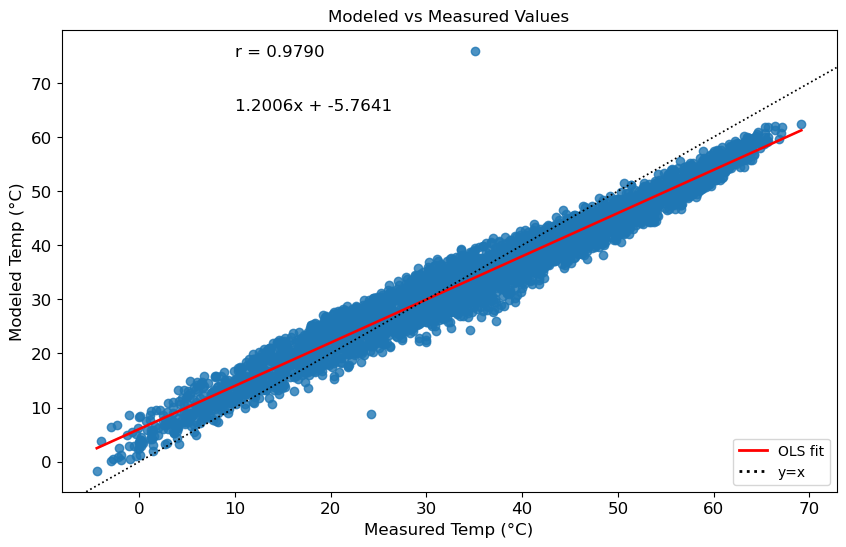

In [8]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled Temp'], y = df.dropna()['Measured module temperature (°C)'])
sns.regplot(x = df['Measured module temperature (°C)'], y = df['Modeled Temp'], line_kws={'color':'red'})
plt.ylabel('Modeled Temp (°C)')
plt.xlabel('Measured Temp (°C)')
plt.text(10, 75, s = f"r = {r:0.04f}")
plt.text(10, 65, s = f"{slope:0.04f}x + {intercept:0.04f}")
plt.axline((0, 0), slope=1, c='k', ls=':')
line_1 = Line2D([0], [0], color='red', linewidth=2, linestyle='-',label='OLS fit') 
line_2 = Line2D([0], [0], color='k', linewidth=2, linestyle=':',label='y=x') 
plt.legend(prop=dict(size='small'), loc='lower right',handles=[line_1, line_2])
plt.title('Modeled vs Measured Values')

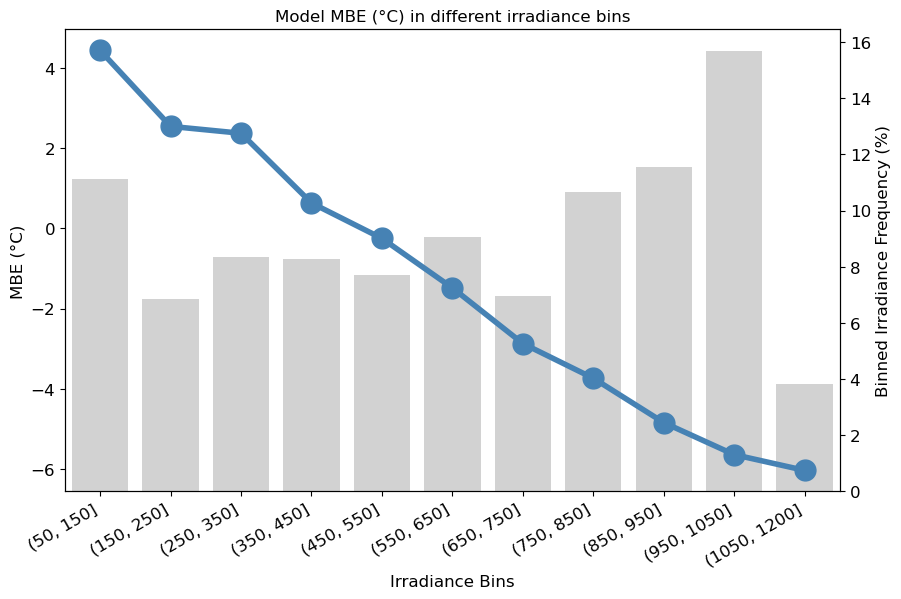

In [9]:
#plotting MBE for each irradiance bin to see performance at different irradiance levels
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts().to_frame()
bins.rename(columns = {'count' : 'Frequency'}, inplace = True)
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']

fig, ax = plt.subplots()
x = binstr
y = df[['Irradiance Bins', 'BE']].groupby('Irradiance Bins', observed=False).mean().sort_values('Irradiance Bins')['BE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=4, markersize=15)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('MBE (°C)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('Model MBE (°C) in different irradiance bins')
plt.show()


## Plotting the difference in modeled/measured temperature & ambient temperature vs POA irradiance
By plotting the difference from module to ambient, for the measured and modeled data, against POA irradiance we can see if the model is considering times when the ambient temperature is larger due to irradiative effects on the module

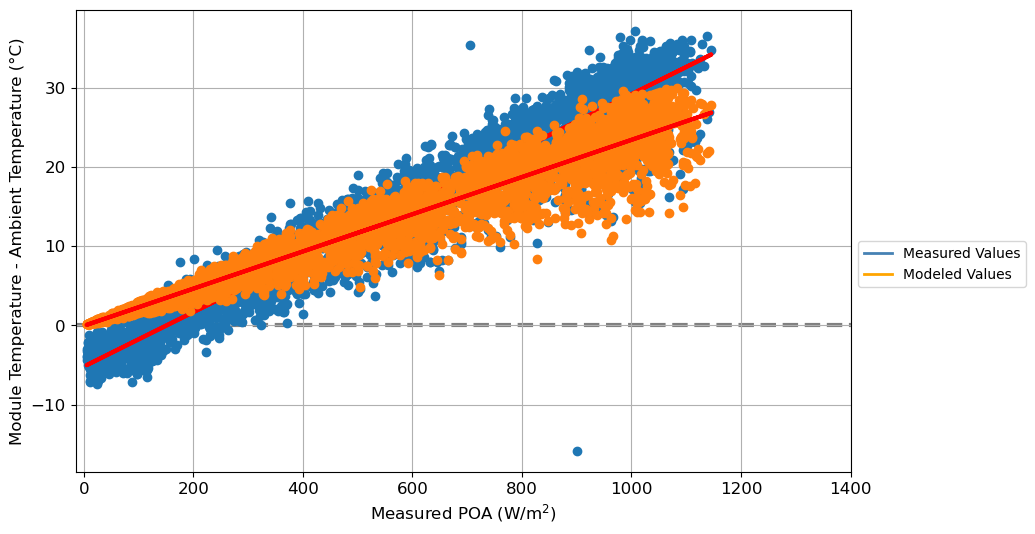

In [10]:
x = df['Measured front POA irradiance (W/m2)']
y = (df['Modeled Temp'] - df['Ambient Temp (°C) '])
y2 = (df['Measured module temperature (°C)'] - df['Ambient Temp (°C) '])
z = np.polyfit(x, y, 1)
z2 = np.polyfit(x, y2, 1)
p = np.poly1d(z)
p2 = np.poly1d(z2)
r = np.corrcoef(x,y)[0][1]
plt.scatter(x=df['Measured front POA irradiance (W/m2)'], y= (df['Measured module temperature (°C)'] - df['Ambient Temp (°C) ']),zorder=2)
plt.plot(x, p2(x), linewidth=3, color='red', zorder=2.5)
plt.scatter(x=df['Measured front POA irradiance (W/m2)'], y= (df['Modeled Temp'] - df['Ambient Temp (°C) ']), zorder=6.5)
plt.plot(x, p(x), linewidth=3, color='red',zorder=7)
plt.hlines(y=0, xmin=-15, xmax=1400, linewidth=3, color='grey',linestyles='--', zorder=0)
plt.xlim(-15,1400)
plt.ylabel('Module Temperature - Ambient Temperature (°C)')
plt.xlabel('Measured POA (W/m$^2$)')
plt.grid(True)

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Measured Values')
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Modeled Values')
lines = [line_1,line_3]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)

### Energy Yield Estimates
We can run two simulations, one using the temperature model and another using true module temperature data to see how much influence the errors of the model have on the overall energy yield

In [11]:
#note: the measured & modeled value for module temp is converted to cell temperature using `pvlib.temperature.sapm_cell_from_module`
#using measured module temp to estimate energy
df['DC Power - Meas Temp'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance'], 
                        temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], 
                        df['Measured front POA irradiance (W/m2)'], deltaT=3), pdc0=module['Pmp'], gamma_pdc=module['Gamma Pmp'])
ann_energy_meas = round(df['DC Power - Meas Temp'].sum()/1000,3)
#using modeled temp to estimate energy
df['DC Power - Model Temp'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Modeled Temp'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=module['Pmp'], gamma_pdc=module['Gamma Pmp'])
ann_energy_model = round(df['DC Power - Model Temp'].sum()/1000,3)
#find overall % diff for annual energy
print('With measured module temperature, predicted annual energy is',ann_energy_meas ,
      'kWh and with modeled module temperature, predicted annual energy is',ann_energy_model , 'kWh')
print('The % difference in energy estimate when using measured vs modeled module temperature is ', 
      round(((ann_energy_model-ann_energy_meas)/ann_energy_meas)*100,3),'%')

With measured module temperature, predicted annual energy is 6705.343 kWh and with modeled module temperature, predicted annual energy is 6806.222 kWh
The % difference in energy estimate when using measured vs modeled module temperature is  1.504 %


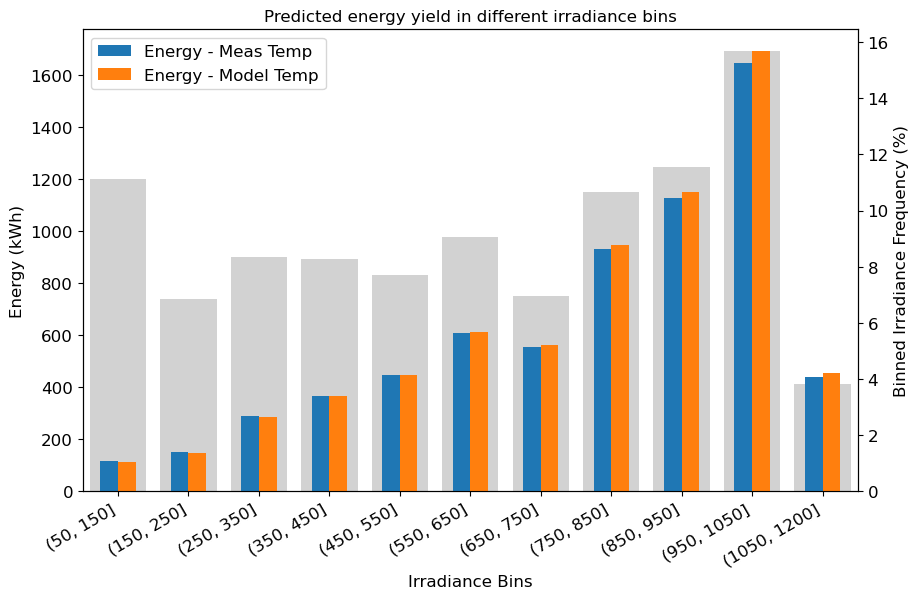

In [12]:
#we can plot the energy produced in each bin of irradiance and see where the largest differences are when using modeled/measured temperature model

bins['Energy - Model Temp'] = df.groupby('Irradiance Bins', observed=False).sum()['DC Power - Model Temp']/1000
bins['Energy - Meas Temp'] = df.groupby('Irradiance Bins', observed=False).sum()['DC Power - Meas Temp']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Meas Temp", "Energy - Model Temp"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)


plt.title('Predicted energy yield in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
## $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

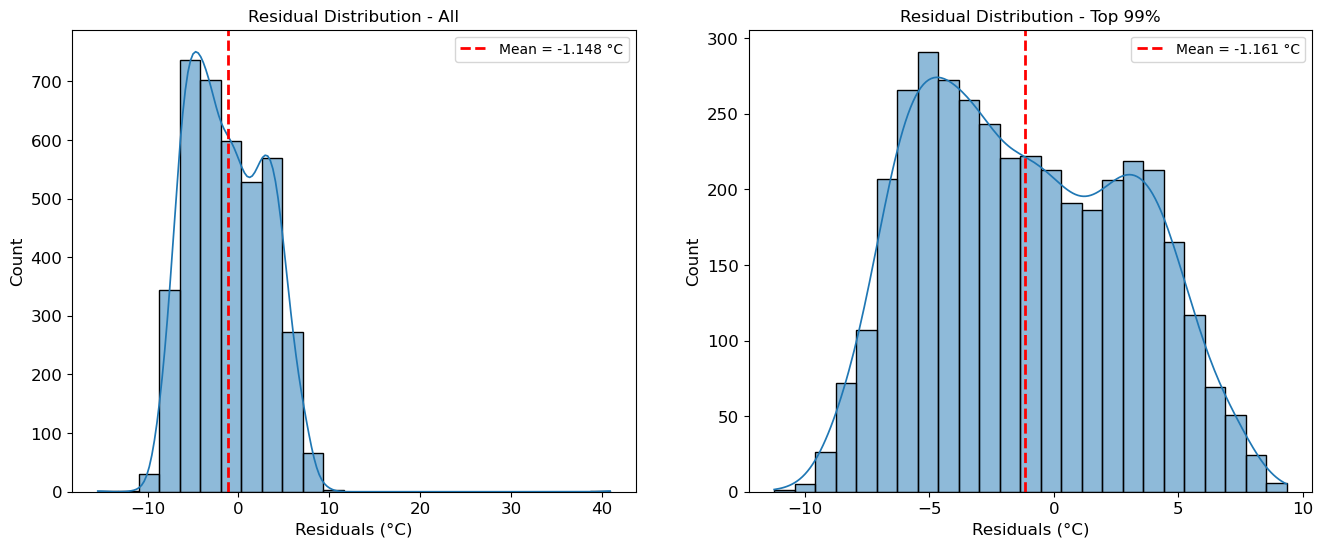

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = df['Modeled Temp'] - df['Measured module temperature (°C)']
#plot them on histogram
hsp = sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
#add vertical line to show mean
ax1.axvline(x=df['Residuals'].mean(), linewidth=2, color='red',linestyle='--', label =('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W/m$^2$'))
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (°C)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' °C'))]
ax1.legend(prop=dict(size='small'),handles=line_4)


#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
hsp = sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
#add vertical line to show mean
ax2.axvline(x=df['resid_trim'].mean(), linewidth=2, color='red',linestyle='--',label =('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W/m$^2$'))
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (°C)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' °C'))]
ax2.legend(prop=dict(size='small'),handles=line_4)

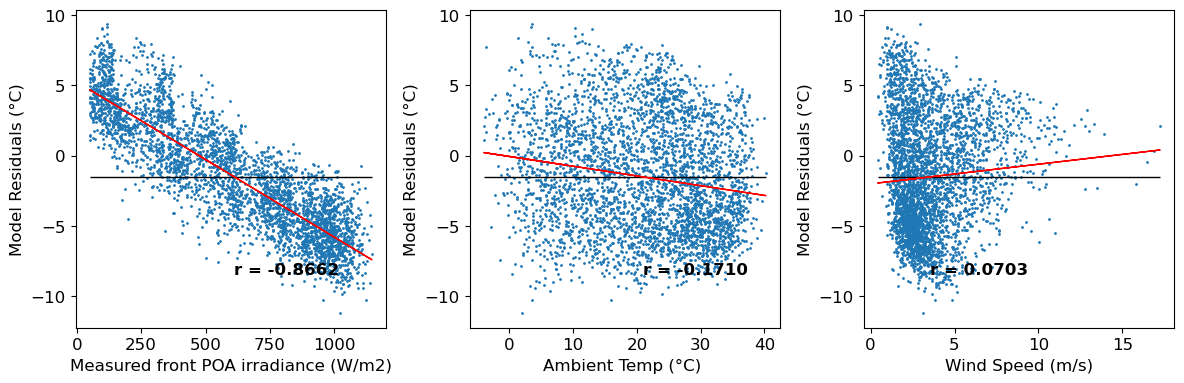

In [14]:
#plot residuals against common inputs into temperature models - high correlation could indicate a weakness in the model's consideration of that variable
df = df.dropna()
covariates = ['Measured front POA irradiance (W/m2)', 'Ambient Temp (°C) ', 'Wind Speed (m/s)']
y = df['resid_trim']
y_avg = df['resid_trim'].mean()
y_med = df['resid_trim'].median()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for covariate, ax in zip(covariates, axes.flatten()):
    x = df[covariate]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r = np.corrcoef(x, y)[0][1]
    
    ax.scatter(x, y, s=1)
    ax.hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black', linestyles='-')
    ax.text(x=x.mean(), y=(y.min() + (-0.25*y.min())), s=f"r = {r:0.04f}", weight='bold')
    ax.plot(x, p(x), linewidth=1, color='red')
    ax.set_xlabel(covariate)
    ax.set_ylabel('Model Residuals (°C)')

fig.tight_layout()

## Plotting residuals vs AOI with division of some metric
Plotting the residuals vs AOI helps to describe the time of day dependence of the model

Text(0.5, 1.0, 'Residuals of Model at High and Low GHI (W/m2) levels')

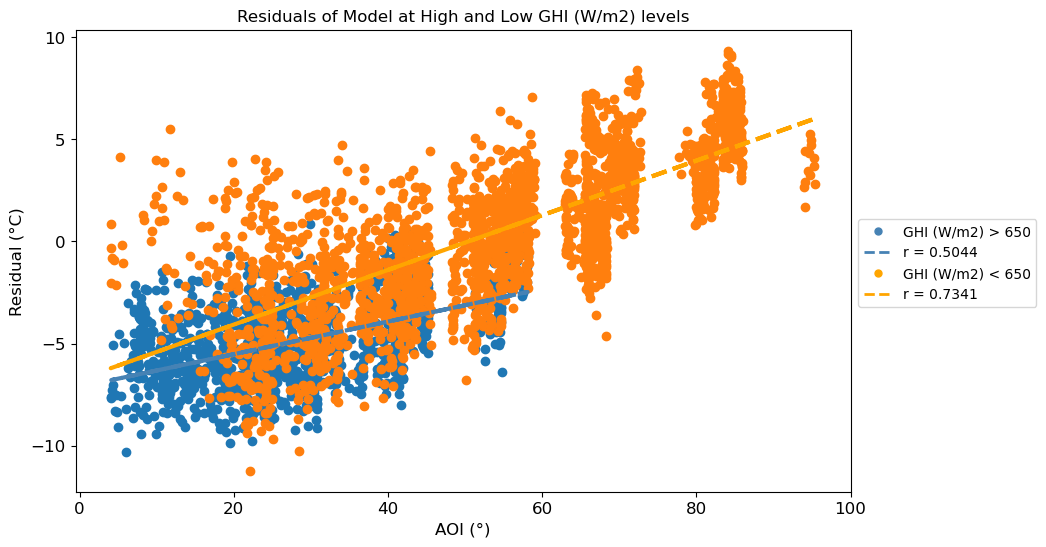

In [15]:
metric = 'GHI (W/m2)' #----------------> could be any value that is a column in the df (wind speed, clearness index, ambient temp)
bound = 650 #--------------------------> the bound at which to separate the upper and lower categories

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

z_h = np.polyfit(df_h['AOI'],df_h['resid_trim'], 1)
p_h = np.poly1d(z_h)
r_h = np.corrcoef(x=df_h['AOI'], y=df_h['resid_trim'])[0][1]

z_l = np.polyfit(df_l['AOI'],df_l['resid_trim'], 1)
p_l = np.poly1d(z_l)
r_l = np.corrcoef(x=df_l['AOI'], y=df_l['resid_trim'])[0][1]

plt.scatter(x=df_h['AOI'], y=df_h['resid_trim'])
plt.plot(df_h['AOI'], p_h(df_h['AOI']), linewidth=3, color='steelblue',linestyle='--',)
plt.scatter(x=df_l['AOI'], y=df_l['resid_trim'])
plt.plot(df_l['AOI'], p_l(df_l['AOI']), linewidth=3, color='orange',linestyle='--')

plt.ylabel('Residual (°C)')
plt.xlabel('AOI (°)')

line_1 = Line2D([], [], color='steelblue',marker='o', linestyle='None',markersize=5, label=(metric+' > '+str(bound)))
line_2 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=f"r = {r_h:0.04f}")
line_3 = Line2D([], [], color='orange',marker='o', linestyle='None',markersize=5, label=(metric+' < '+str(bound)))
line_4 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=f"r = {r_l:0.04f}")

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('Residuals of Model at High and Low '+metric+' levels')

### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the throughout within the months 

Text(0.5, 1.0, 'Model Residuals by Month')

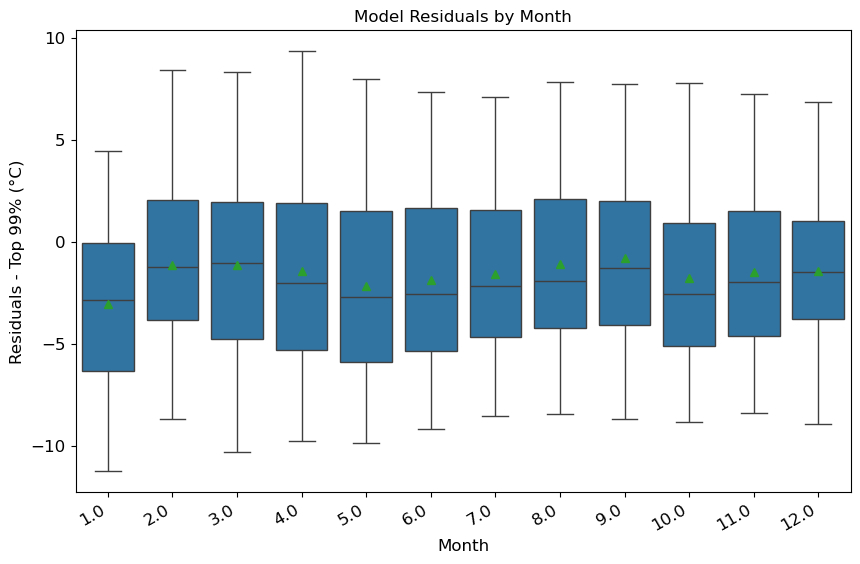

In [16]:
sns.boxplot(data=df, x='Month', y='resid_trim', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Residuals - Top 99% (°C)')
plt.title('Model Residuals by Month')

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day

Text(0.5, 0, 'Solar Azimuth')

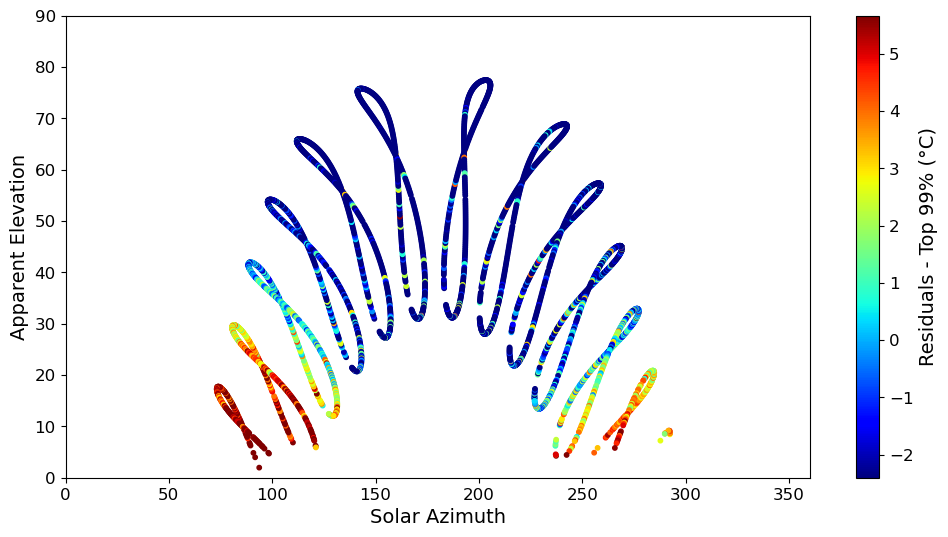

In [17]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['resid_trim'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('Residuals - Top 99% (°C)',fontsize =14)
plt.clim((df['resid_trim'].quantile(0.75) - df['resid_trim'].std()),(df['resid_trim'].quantile(0.75) + df['resid_trim'].std()))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

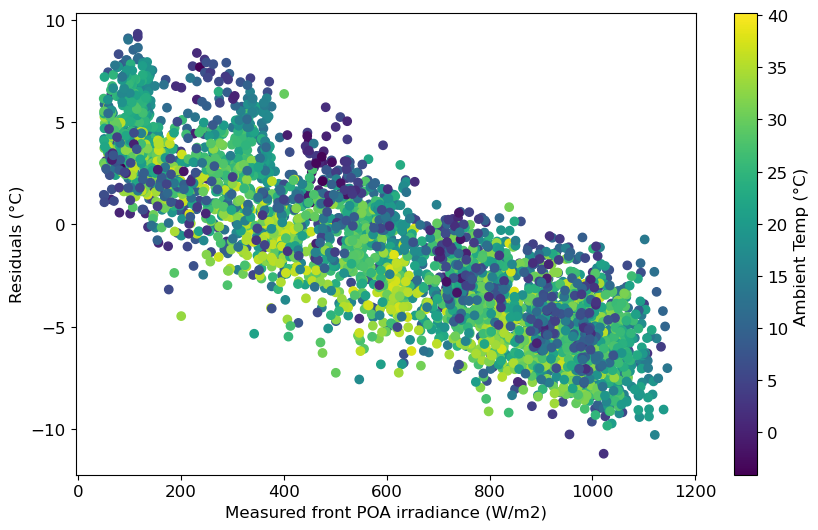

In [18]:
#plotting the residuals vs a parameter with the color representing a third parameter
x = 'Measured front POA irradiance (W/m2)'
c = 'Ambient Temp (°C) '

plt.scatter(df[x], df['resid_trim'], c=df[c])
plt.ylabel('Residuals (°C)')
plt.xlabel(x)
plt.colorbar(label=c)

### Empirical Cumulative Distribution Plot (ECDF)

Text(0.5, 1.0, 'ECDF of Model Residuals - Top 99%')

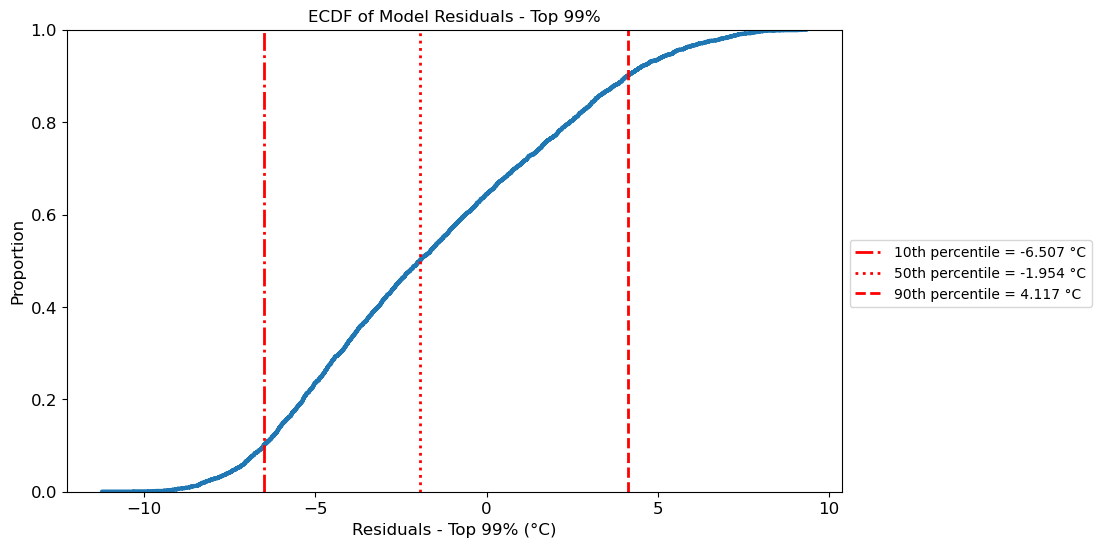

In [19]:
#plot empirical cumulative distribution functions - another way to visualize the distribution of the residuals
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (°C)')
perc10 = df['resid_trim'].quantile(0.1)
perc50 = df['resid_trim'].quantile(0.5)
perc90 = df['resid_trim'].quantile(0.9)
plt.axvline(perc10, linewidth=2, color='red', linestyle='-.', label=f'10th percentile = {perc10:0.03f} °C')
plt.axvline(perc50, linewidth=2, color='red', linestyle='dotted', label=f'50th percentile = {perc50:0.03f} °C')
plt.axvline(perc90, linewidth=2, color='red', linestyle='--', label=f'90th percentile = {perc90:0.03f} °C')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.title('ECDF of Model Residuals - Top 99%')

Text(0.5, 1.0, 'ECDF of Model at High and Low Wind Speed (m/s) levels')

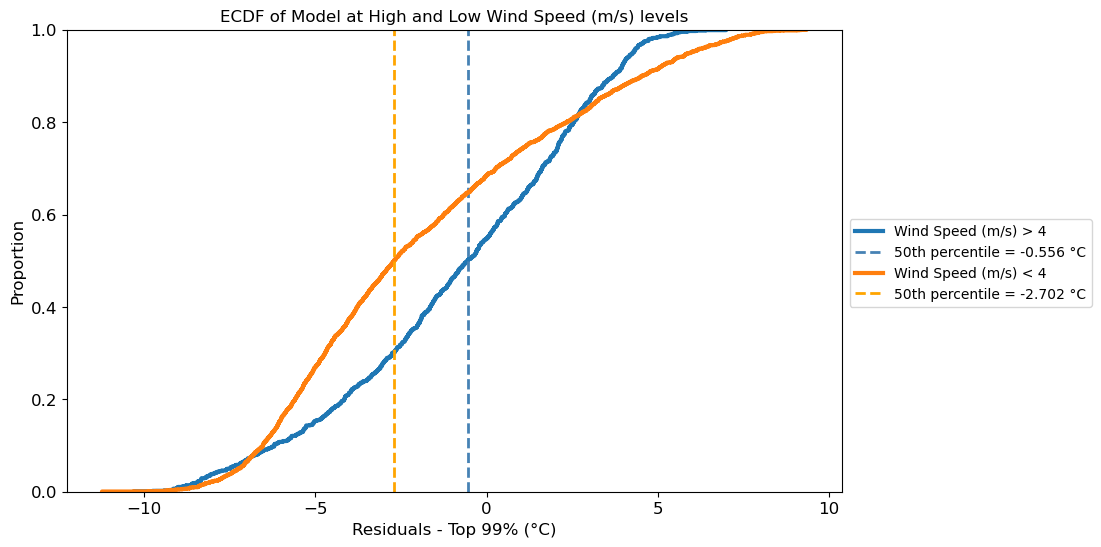

In [20]:
metric = 'Wind Speed (m/s)' #<---------------- could be any value that is a column in the df (wind speed, clearness index, ambient temp)
bound = 4 #<------------------------------ the bound at which to separate the upper and lower categories

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

perc50_h = df_h['resid_trim'].quantile(0.5)
perc50_l = df_l['resid_trim'].quantile(0.5)

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3, label=(metric+' > '+str(bound)))
plt.axvline(perc50_h, linewidth=2, color='steelblue', linestyle='--', label=f'50th percentile = {perc50_h:0.03f} °C')
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3, label = (metric+' < '+str(bound)))
plt.axvline(perc50_l, linewidth=2, color='orange', linestyle='--', label=f'50th percentile = {perc50_l:0.03f} °C')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.xlabel('Residuals - Top 99% (°C)')
plt.title('ECDF of Model at High and Low '+metric+' levels')

### Analysis III: Comparison to Baseline Models
#### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models
In this analysis, the selected baseline is the `pvlib.temperature.sapm_module` temperature model

In [21]:
baseline_model = 'SAPM'
tmp = (pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'])
df['Baseline Model Temp'] = pvlib.temperature.sapm_module(poa_global=df['Measured front POA irradiance (W/m2)'], temp_air=df['Ambient Temp (°C) '],
                                wind_speed=df['Wind Speed (m/s)'],a=tmp['a'], b=tmp['b'])
#calculate some basic error metrics
df['Baseline Residuals'] = df['Baseline Model Temp'] - df['Measured module temperature (°C)']

In [22]:
#using modeled temp to estimate energy
df['DC Power - Baseline Model Temp'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Baseline Model Temp'], df['Measured front POA irradiance (W/m2)'],
                                                                    deltaT=3),pdc0=module['Pmp'], gamma_pdc=module['Gamma Pmp'])
ann_energy_baseline =  round(df['DC Power - Baseline Model Temp'].sum()/1000,3)
#find overall % diff for annual energy
print('With the initial modeled module temperature, predicted annual energy is', ann_energy_model,
      'kWh and with baseline modeled module temperature, predicted annual energy is',ann_energy_baseline, 'kWh')
print('The % difference in energy estimate when using the initial temperature model vs the baseline modeled module temperature is ', 
      round(((ann_energy_baseline-ann_energy_model)/ann_energy_model)*100,3),'%')

With the initial modeled module temperature, predicted annual energy is 6806.222 kWh and with baseline modeled module temperature, predicted annual energy is 6810.411 kWh
The % difference in energy estimate when using the initial temperature model vs the baseline modeled module temperature is  0.062 %


Text(0.5, 1.0, 'Residuals for Model & Baseline Model')

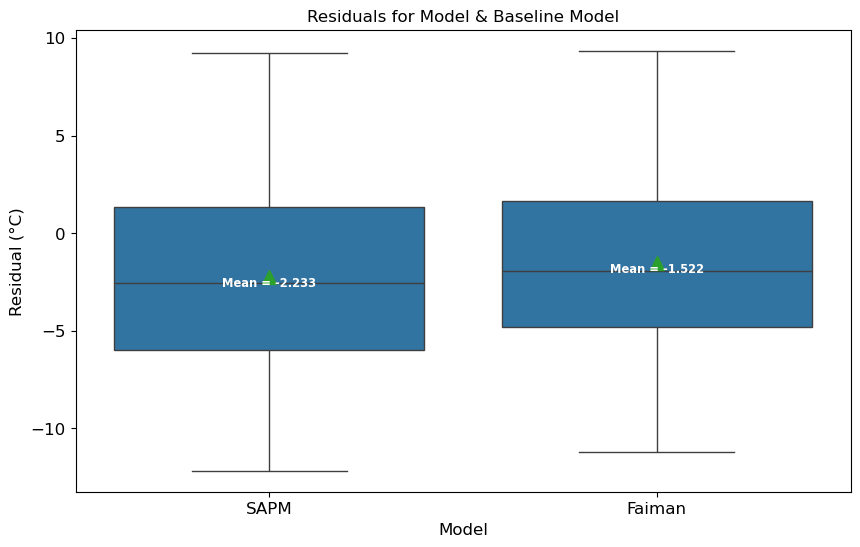

In [23]:
#put the model and baseline model residuals in one df for easy analysis
resid_df = pd.concat([
    pd.DataFrame({'Residual': df['Baseline Model Temp'] - df['Measured module temperature (°C)'], 'Model': baseline_model,}),
    pd.DataFrame({'Residual': df['Modeled Temp'] - df['Measured module temperature (°C)'],'Model':model_name ,})
], ignore_index=True)

box_plot = sns.boxplot(x='Model', y='Residual', data=resid_df, showfliers=False, showmeans=True, meanprops={'markersize':10})
plt.ylabel('Residual (°C)')
#view the numerical value of mean on plot
means = resid_df.groupby(['Model'])['Residual'].mean()
vertical_offset = resid_df['Residual'].mean() * 0.25 # offset from mean for display
for xtick in box_plot.get_xticks():
    if xtick == 0:
        name = baseline_model
    else:
        name = model_name
    box_plot.text(xtick,means[name] + vertical_offset,('Mean = '+str(round(means[name],3))),horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.title('Residuals for Model & Baseline Model')

Text(0.5, 1.0, 'ECDF of Model & Baseline Model Residuals')

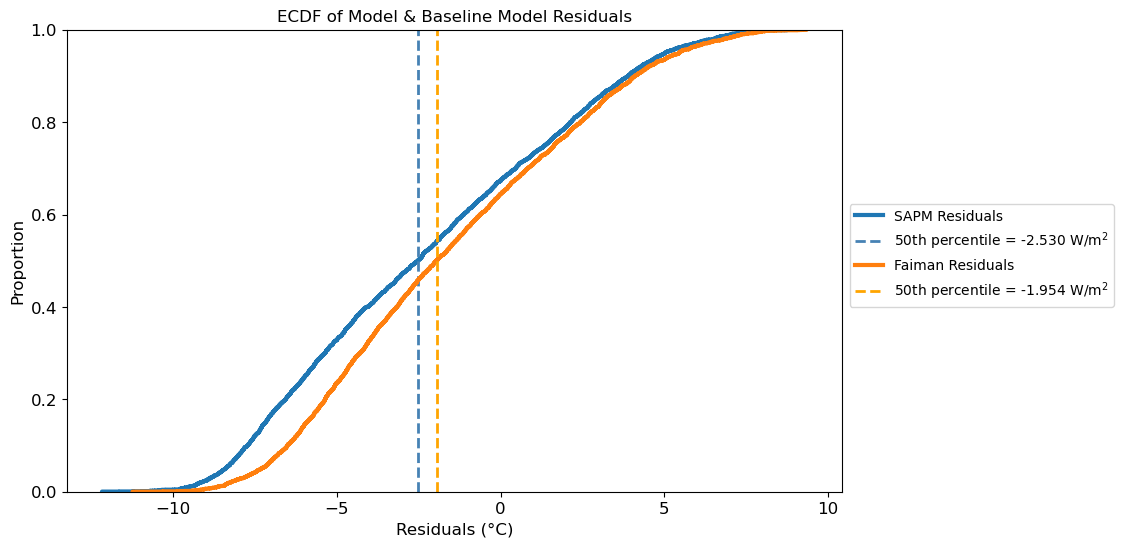

In [24]:
#ecdf of the two models overlayed & p50 for each

perc50_m = np.percentile(df['Residuals'].dropna(), 50)
perc50_b = np.percentile(df['Baseline Residuals'].dropna(), 50)

sns.ecdfplot(data=df, x='Baseline Residuals', linewidth=3, label = (baseline_model+' Residuals'))
plt.axvline(x=perc50_b, linewidth=2, color='steelblue', linestyle='--', label=f'50th percentile = {perc50_b:0.03f} W/m$^2$')
sns.ecdfplot(data=df, x='Residuals', linewidth=3, label=(model_name+' Residuals'))
plt.axvline(x=perc50_m, linewidth=2, color='orange', linestyle='--', label=f'50th percentile = {perc50_m:0.03f} W/m$^2$')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.xlabel('Residuals (°C)')
plt.title('ECDF of Model & Baseline Model Residuals')

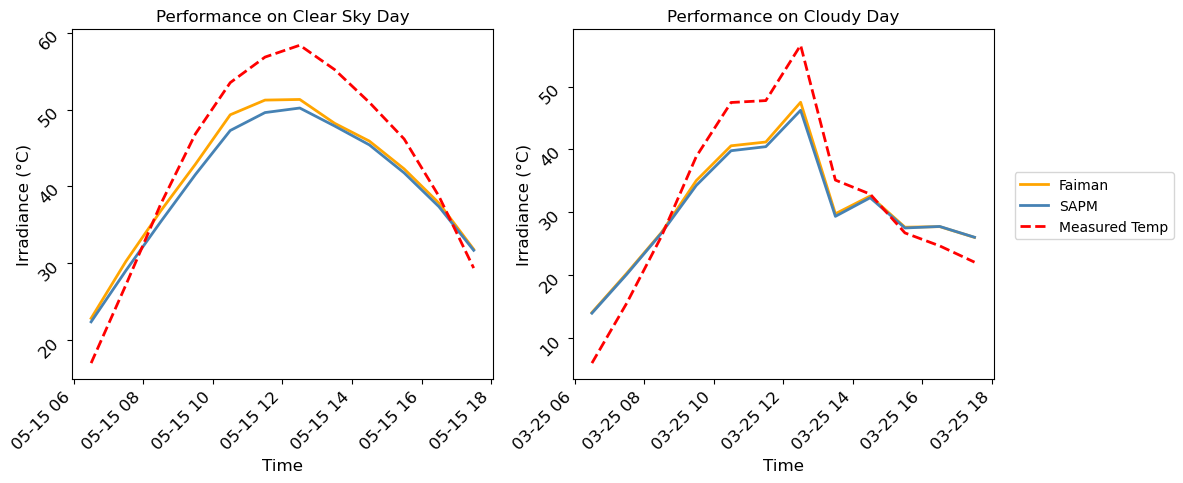

In [25]:
# diurnal plots help visualize the differences between modeled and measured module temperature as well as model and baseline temperature model performance

dates = [('Clear Sky', '2021-05-15'),('Cloudy', '2021-03-25'),]

fig, axes = plt.subplots(1, len(dates), figsize=(12,5))

for (sky_condition, date), ax in zip(dates, axes):
    df.loc[date, 'Modeled Temp'].plot(ax=ax, linewidth=2, color='orange', label = model_name)
    df.loc[date, 'Baseline Model Temp'].plot(ax=ax, linewidth=2, color='steelblue',label = baseline_model)
    df.loc[date, 'Measured module temperature (°C)'].plot(ax=ax, linewidth=2, linestyle='dashed', color='red', label = 'Measured Temp')
    ax.tick_params(labelrotation = 45)
    ax.set_ylabel('Irradiance (°C)')
    ax.set_xlabel('Time')
    ax.set_title(f'Performance on {sky_condition} Day')

axes[-1].legend(prop=dict(size='small'), loc=[1.05, 0.4])
fig.tight_layout()

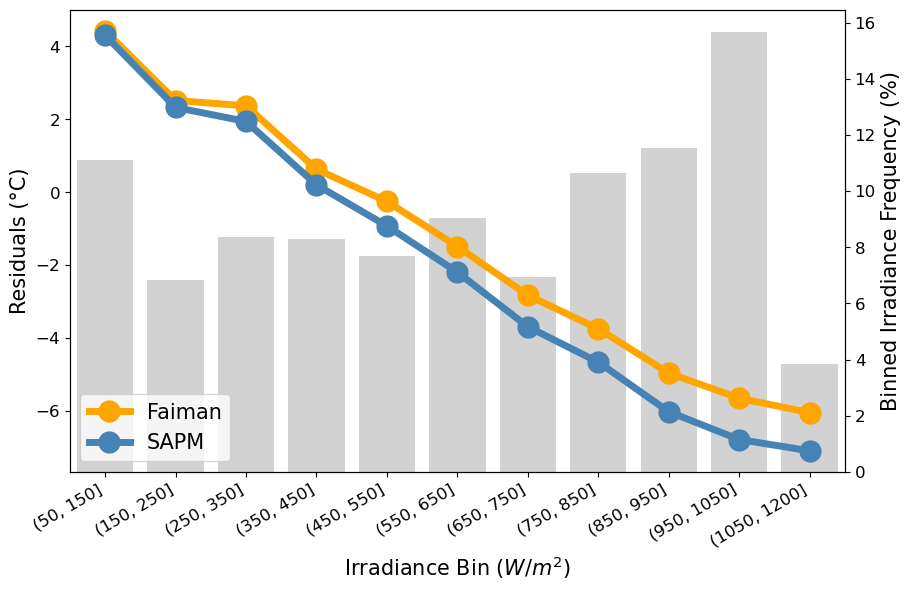

In [27]:
#plotting the model's residuals at different irradiance levels
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts().to_frame()
bins.rename(columns = {'count' : 'Frequency'}, inplace = True)
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']

fig, ax = plt.subplots()
x = binstr
y =  df[['Irradiance Bins', 'Residuals']].groupby('Irradiance Bins', observed=False).mean().sort_values('Irradiance Bins')['Residuals']
ax.plot(x, y, 'orange', marker='o', zorder=6.5, linewidth=5, markersize=15)
y = df[['Irradiance Bins', 'Baseline Residuals']].groupby('Irradiance Bins', observed=False).mean().sort_values('Irradiance Bins')['Baseline Residuals']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=5, markersize=15)
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('Residuals (°C)', fontsize=15)
ax.set_xlabel('Irradiance Bin ($W/m^2$)', fontsize=15)
ax.legend([model_name,baseline_model],loc='lower left', fontsize=15)

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

This work was supported by the U.S. Department of Energy’s Office of Energy Efficiency and Renewable Energy (EERE) under the Solar Energy Technologies Office Award Number 38267. 
Sandia National Laboratories is a multimission laboratory managed and operated by National Technology & Engineering Solutions of Sandia, LLC, a wholly owned subsidiary of 
Honeywell International Inc., for the U.S. Department of Energy’s National Nuclear Security Administration under contract DE-NA0003525. This paper describes objective technical results 
and analysis. Any subjective views or opinions that might be expressed in the paper do not necessarily represent the views of the U.S. Department of Energy or the United States Government